In [24]:
scan_fov = 4.7
scan_beams = 1080
angle_min = -scan_fov/2.
angle_max = scan_fov/ 2.
angle_inc = scan_fov / scan_beams

In [25]:
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import pickle

In [26]:
def polar_to_cart(theta, r):
    """
    Assumes theta in radians & returns x,y
    """
    x = r*np.cos(theta)
    y = r*np.sin(theta)
    return x,y
    
def lidar_polar_to_cart(ranges, angle_min, angle_increment):
    """
    Convert a lidar_dict to cartesian & return x_ranges & y_ranges
    """
    x_ranges = []
    y_ranges = []
    for i, r in enumerate(ranges):
        if r == np.nan:
            x_ranges.append(1000000)
            y_ranges.append(1000000)
        else:
            theta = angle_min + i * angle_increment
            x, y = polar_to_cart(theta + math.pi/2, r*100.0)
            x_ranges.append(x)
            y_ranges.append(y)
    return x_ranges, y_ranges

In [27]:
folderpath = '../data/sim_train/'
pkl_list = os.listdir(folderpath)
pkl_list.sort()
pkl_list = pkl_list[:]

In [28]:
X = np.zeros((len(pkl_list), 1080))
for i, pkl_name in enumerate(pkl_list):
    with open(os.path.join(folderpath, pkl_name), 'rb') as f:
        pkl_dict = pickle.load(f)
        scans = pkl_dict["obs"]["scans"]
        X[i, :] = np.array(scans)

In [29]:
from sklearn.cluster import KMeans
km = KMeans(
    n_clusters=10, init='random',
    n_init=10, max_iter=300,
)
y_km = km.fit_predict(X)

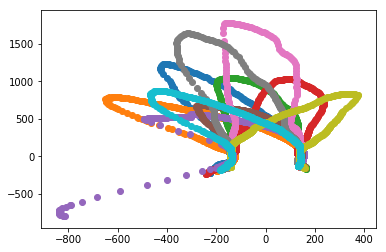

In [30]:
centers = km.cluster_centers_
for i in range(len(centers)):
    ranges = centers[i, :]
    xranges, yranges = lidar_polar_to_cart(ranges, angle_min, angle_inc)
    plt.scatter(xranges, yranges)

In [31]:
pickle.dump(centers, open('means.pkl', 'wb'))